In [1]:
! pip install pytorch-lightning==2.0.1 --quiet
! pip install lightning-bolts --quiet

In [2]:
import torch
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
# from pl_bolts.models.autoencoders.components import (
#     resnet18_decoder,
#     resnet18_encoder,
# )

from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
import torchvision.transforms as T
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1- Define Model

In [3]:
class VAE(pl.LightningModule):
  def __init__(self,enc_out_dim=32, latent_dim=512, featureDim=256 *26 *26):

    super().__init__()

    self.save_hyperparameters()

    # self.encoder = resnet18_encoder(first_conv=False, maxpool1=False)
    # self.decoder = resnet18_decoder(latent_dim = latent_dim, input_height=input_height, first_conv=False,maxpool1=False)

    # encoder layers
    self.encConv1 = nn.Conv2d(4,64,3)
    self.encConv2 = nn.Conv2d(64,128,3)
    self.encConv3 = nn.Conv2d(128,256,3)
    self.fc_mu = nn.Linear(featureDim,latent_dim)
    self.fc_var = nn.Linear(featureDim, latent_dim)

    # decoder layers
    self.deFC1 = nn.Linear(latent_dim + 10, featureDim)
    self.deConv1 = nn.ConvTranspose2d(256,128,3)
    self.deConv2 = nn.ConvTranspose2d(128,64,3)
    self.deConv3 = nn.ConvTranspose2d(64,3,3)

    self.log_scale = nn.Parameter(torch.Tensor([0.0]))

  def encoder(self,x,y):

    # add label to image
    y = torch.argmax(y, dim=1).reshape((y.shape[0],1,1,1))
    y = torch.ones((x.shape[0],1,x.shape[2],x.shape[3])).to('cuda')*y #.to('cuda')*y #1,28,28
    t = torch.cat((x,y),dim=1)

    x = F.relu(self.encConv1(t))
    x = F.relu(self.encConv2(x))
    x = F.relu(self.encConv3(x))
    batch_size = x.shape[0]
    x = x.view(batch_size,-1)
    return x

  def decoder(self,z,y):
    z = torch.cat((z, y.float()), dim=1) # b, 256 + 10
    x_hat = F.relu(self.deFC1(z))
    x_hat = x_hat.view(-1,256,26,26)
    x_hat = F.relu(self.deConv1(x_hat))
    x_hat = F.relu(self.deConv2(x_hat))
    x_hat = torch.sigmoid(self.deConv3(x_hat))

    return x_hat

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-4)

  def kl_divergence(self,z,mu,std):

    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    kl = (log_qzx - log_pz)
    kl = kl.sum(-1)
    return kl

  def gaussian_likelihood(self,mean,logscale,sample):
    scale   = torch.exp(logscale)
    dist    = torch.distributions.Normal(mean,scale)
    log_pxz = dist.log_prob(sample)

    return log_pxz.sum(dim=(1,2,3))


  def forward(self,x,y):
    x_encoded = self.encoder(x,y)

    mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
    std = torch.exp(log_var/2)
    q = torch.distributions.Normal(mu,std)
    z = q.rsample()

    x_hat = self.decoder(z,y)
    return x_hat

  def training_epoch_end(self,outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()

        print("****Training****")
        print(f'Epoch {self.current_epoch}: Train loss {loss}')

  def training_step(self,batch,batch_idx):

    x, y = batch # y - 2,3,4..
    y = F.one_hot(y, num_classes = 10) # one hot y

    x_encoded = self.encoder(x.to('cuda'),y.to('cuda'))
    mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

    std = torch.exp(log_var/2)
    q = torch.distributions.Normal(mu,std)
    z = q.rsample()

    x_hat = self.decoder(z,y.to('cuda'))

    recon_loss = self.gaussian_likelihood(x_hat,self.log_scale,x)
    #kl = self.kl_divergence(z,mu,std)
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    elbo = kl - recon_loss
    elbo = elbo.mean()

    # recon_loss = F.mse_loss(x_hat, x, reduction='sum')
    # kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    # elbo = kl + recon_loss
    # elbo = elbo.mean()

    self.log_dict({
        'elbo': elbo,
        'kl': kl.mean(),
        'recon_loss': recon_loss.mean(),
        'reconstruction': recon_loss.mean(),
        'kl': kl.mean(),
    })
    return elbo

In [4]:
# check the dimensions
my_vae_check = VAE()
print(my_vae_check)

x = torch.rand(1,3,32,32)
y = np.zeros((1, 10))
y[np.arange(1), 1] = 1
y = torch.tensor(y)
my_vae_check(x,y).shape

VAE(
  (encConv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1))
  (encConv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (encConv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc_mu): Linear(in_features=173056, out_features=512, bias=True)
  (fc_var): Linear(in_features=173056, out_features=512, bias=True)
  (deFC1): Linear(in_features=522, out_features=173056, bias=True)
  (deConv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (deConv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (deConv3): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1))
)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

# 2 - Data

In [5]:
dataset = CIFAR10(root='data',train=True,transform=transforms.ToTensor(),download=True)
train_dataloader = DataLoader(dataset = dataset, batch_size=32,shuffle=True)

dataset_test = CIFAR10(root='data',train=False,transform=transforms.ToTensor(),download=True)
test_dataloader = DataLoader(dataset = dataset_test, batch_size=32,shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 83773262.92it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [6]:
next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[1].shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

# 3 - Train Model

In [7]:
pl.seed_everything(1234)
my_vae = VAE().to('cuda')
trainer = pl.Trainer(gpus=1, max_epochs=30,)
trainer.fit(my_vae,train_dataloader ,test_dataloader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


Training: 0it [00:00, ?it/s]

****Training****
Epoch 0: Train loss 2717.65185546875
****Training****
Epoch 1: Train loss 2248.268310546875
****Training****
Epoch 2: Train loss 1818.858154296875
****Training****
Epoch 3: Train loss 1406.7467041015625
****Training****
Epoch 4: Train loss 1015.3547973632812
****Training****
Epoch 5: Train loss 648.6443481445312
****Training****
Epoch 6: Train loss 316.1893310546875
****Training****
Epoch 7: Train loss 20.566564559936523
****Training****
Epoch 8: Train loss -228.0672607421875
****Training****
Epoch 9: Train loss -443.8179016113281
****Training****
Epoch 10: Train loss -643.5443725585938
****Training****
Epoch 11: Train loss -758.2279052734375
****Training****
Epoch 12: Train loss -812.2986450195312
****Training****
Epoch 13: Train loss -850.3138427734375
****Training****
Epoch 14: Train loss -893.0704345703125
****Training****
Epoch 15: Train loss -931.8402099609375
****Training****
Epoch 16: Train loss -976.6140747070312
****Training****
Epoch 17: Train loss -1008.033

# 4 - Plot Images

In [8]:
# plot images
def generate_image(x, y, wrong_y, model,num_predictions=25):
    figure(figsize=(8, 3), dpi=300)
    t2img = T.ToPILImage()
    cifar10_labels = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    with torch.no_grad():

        wrong_y_one_hot = F.one_hot(wrong_y, num_classes = 10)
        y_one_hot = F.one_hot(y, num_classes = 10)
        x_encoded   = model.encoder(x.to('cuda'),wrong_y_one_hot.to('cuda'))
        mu, log_var = model.fc_mu(x_encoded), model.fc_var(x_encoded)

        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu,std)
        z = q.rsample()

        x_hat = model.decoder(z,wrong_y_one_hot.to('cuda'))

        fig = plt.figure(figsize=(10,10))

        for idx in np.arange(num_predictions):

          ax = fig.add_subplot(5,5,idx + 1,xticks=[],yticks=[])
          img = x_hat[idx].to('cpu')
          plt.imshow(img.permute(1,2,0))
          ax.set_title(f"Label/Image: {cifar10_labels[wrong_y[idx]]} / {cifar10_labels[y[idx]]}")

        fig.tight_layout()
        plt.show()

        #img = make_grid(x_hat, nrow=8)
        #plt.imshow(t2img(make_grid(x_hat, nrow=8)), interpolation='nearest')

<Figure size 2400x900 with 0 Axes>

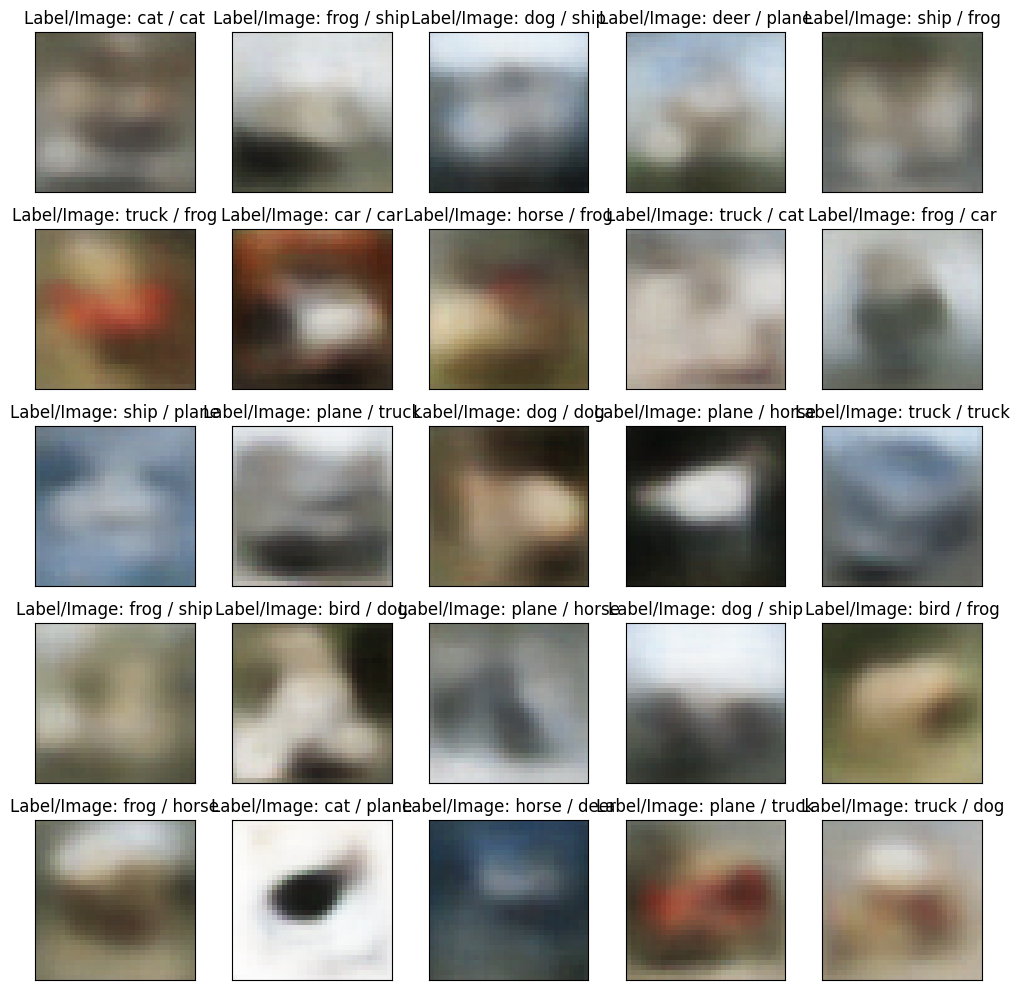

In [9]:
x, y = next(iter(test_dataloader))
wrong_y = torch.tensor(np.random.choice(10,size = 32))
generate_image(x,y,wrong_y,my_vae.to('cuda'))